<a href="https://colab.research.google.com/github/GMobinit/cat_dog_recognition_model/blob/image_dataset_from_directory/cat_dog_recognition_using_image_dataset_from_directory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [8]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
print(path_to_zip)
PATH = os.path.join(path_to_zip,'cats_and_dogs_filtered')
print(PATH)

/root/.keras/datasets/cats_and_dogs_extracted
/root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered


In [9]:
train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')
print(train_dir)
print(validation_dir)

BATCH_SIZE = 32
IMG_SIZE = (160,160)

/root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_extracted/cats_and_dogs_filtered/validation
Found 2000 files belonging to 2 classes.


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


In [13]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


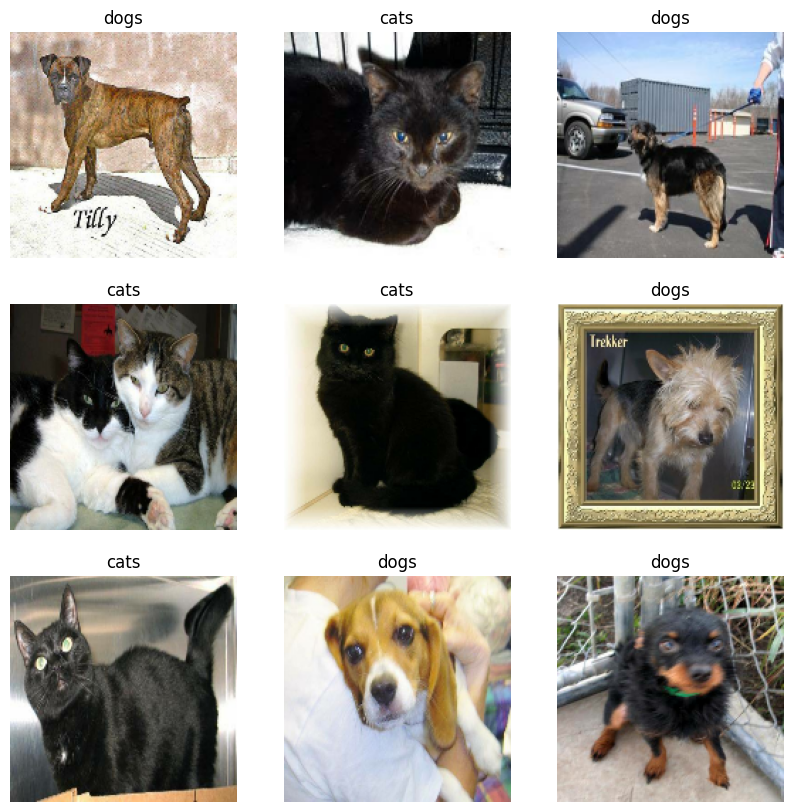

In [14]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [15]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches//5)
validation_dataset = val_ds.skip(val_batches//5)

In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6
